In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr
import seaborn as sns

from matplotlib.colors import Normalize, to_hex

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set seed
seed = 8888
rng = np.random.default_rng(seed)

# Get point colours from colourmap
norm = Normalize(vmin=-0.5, vmax=1.5)
cmap1 = plt.get_cmap('Greys')
cmap2 = plt.get_cmap('Reds')

# Map each scalar to a color
blacks = [to_hex(cmap1(norm(value))) for value in [0,1]]
reds = [to_hex(cmap2(norm(value))) for value in [0,1]]

def jitter_points(n_points=10):
    jitter = np.random.normal(0,0.05,size=n_points)
    
    return jitter

# 1. State a clear question
- What is the causal effect of age at marriage on the divorce rate?

### Load data
The dataframe consists of the marriage and divorce rates, the population and the number of waffle houses in various states of the United States.

In [3]:
df = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/Python/pymc/pymc-resources/Rethinking_2/Data/WaffleDivorce.csv', sep=';')
df = df.loc[:,['MedianAgeMarriage', 'Marriage', 'Divorce']]
df.head()

,MedianAgeMarriage,Marriage,Divorce
0,25.3,20.2,12.7
1,25.2,26.0,12.5
2,25.8,20.3,10.8
3,24.3,26.4,13.5
4,26.8,19.1,8.0


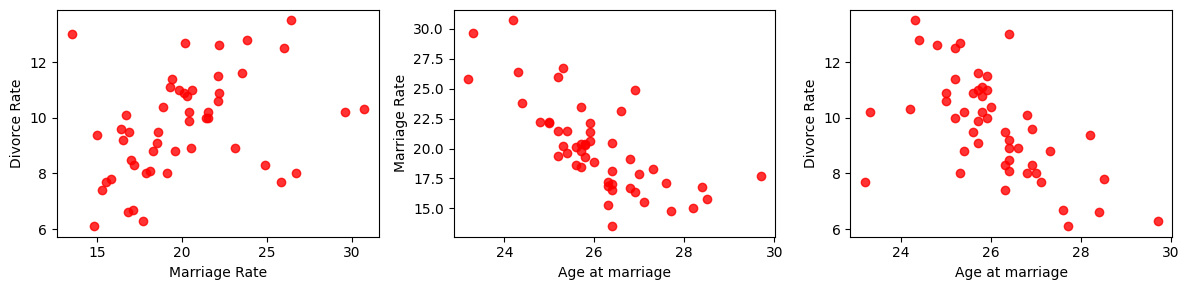

In [4]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))

ax1.scatter(df['Marriage'], df['Divorce'], c='red', alpha=0.8)
ax1.set_xlabel('Marriage Rate')
ax1.set_ylabel('Divorce Rate')

ax2.scatter(df['MedianAgeMarriage'], df['Marriage'], c='red', alpha=0.8)
ax2.set_xlabel('Age at marriage')
ax2.set_ylabel('Marriage Rate')

ax3.scatter(df['MedianAgeMarriage'], df['Divorce'], c='red', alpha=0.8)
ax3.set_xlabel('Age at marriage')
ax3.set_ylabel('Divorce Rate')

plt.tight_layout()
plt.show()

# 2. Sketch out the causal assumptions (DAG) of the model
M &rarr; D  
&uarr; ↗  
A

# 5. Analyse data
Here, we jump directly to analysing the data as we went through the exact same example in notebook 5.

In [5]:
df_sampled = df.sample(n=len(df))

df_sampled['marriage_z'] = (df_sampled['Marriage'] - df_sampled['Marriage'].mean()) / df_sampled['Marriage'].std()
df_sampled['divorce_z'] = (df_sampled['Divorce'] - df_sampled['Divorce'].mean()) / df_sampled['Divorce'].std()
df_sampled['age_z'] = (df_sampled['MedianAgeMarriage'] - df_sampled['MedianAgeMarriage'].mean()) / df_sampled['MedianAgeMarriage'].std()

In [6]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Define likelihood
    divorce_z_obs = pm.Normal('divorce_z_obs', mu=alpha + beta_A * df_sampled['age_z'] + beta_M * df_sampled['marriage_z'], sigma=sigma, observed=df_sampled['divorce_z'].values)
    
    # Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.103,-0.189,0.193,0.002,0.002,3293.0,2520.0,1.0
beta_A,-0.605,0.159,-0.898,-0.297,0.003,0.002,2901.0,2333.0,1.0
beta_M,-0.056,0.159,-0.352,0.247,0.003,0.002,3030.0,2613.0,1.0
sigma,0.825,0.086,0.674,0.993,0.002,0.001,3171.0,2173.0,1.0


The above model is the same as we ran in chapter 5. We will now replace the gausian nature of the model to a student T distribution. This will make the model more robust to outliers (in this case, Maine and Idaho which have unusual divorce rates considering their median marriage age).

In [7]:
with pm.Model() as model_T:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Define likelihood
    divorce_z_obs = pm.StudentT('divorce_z_obs', nu=2, mu=alpha + beta_A * df_sampled['age_z'] + beta_M * df_sampled['marriage_z'], sigma=sigma, observed=df_sampled['divorce_z'].values)
    
    # Inference
    idata_T = pm.sample(1000)
    
az.summary(idata_T)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.024,0.100,-0.175,0.201,0.002,0.001,4377.0,3163.0,1.0
beta_A,-0.694,0.152,-0.979,-0.411,0.003,0.002,2504.0,2650.0,1.0
beta_M,0.052,0.208,-0.318,0.461,0.004,0.003,2769.0,2638.0,1.0
sigma,0.579,0.086,0.415,0.737,0.001,0.001,3519.0,2958.0,1.0


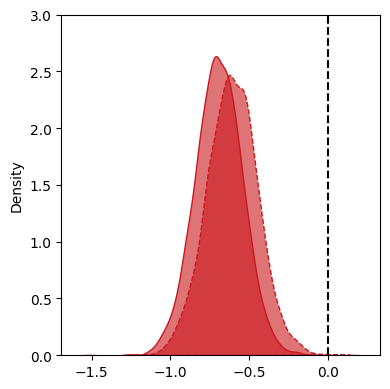

In [15]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

sns.kdeplot(idata.posterior['beta_A'].values.reshape(-1), color=reds[1], fill=True, alpha=0.6, linestyle='dashed', ax=ax)
sns.kdeplot(idata_T.posterior['beta_A'].values.reshape(-1), color=reds[1], fill=True, alpha=0.6, ax=ax)

ax.vlines(x=0, ymin=0, ymax=3, color='black', linestyle='dashed')
ax.set_ylim(0,3)

plt.tight_layout()
plt.show()

Since we used the student T distribution, we see that our model has become more robust to the outliers. It has become narrower and taller than our gaussian model. This happens because the student T distribution can be thought of as a mixture of gaussians. This causes the summed distribution to have heavier tails, thus making the model less surprised / influenced by outlier points.

This makes student T distributions a great choice in under-theorised domains!